In [3]:
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import itertools
import operator
import warnings
import matplotlib.pyplot as plt

from statistics import mean
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from sklearn.metrics import precision_score, confusion_matrix, f1_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, roc_auc_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.utils import resample, shuffle

In [4]:
from IPython.display import Image

In [ ]:
def class_balance(x, y, perc, option='upsample'):
    """
    resampling function, makes easy to be called in a customized CV function later
    """    
    X = pd.concat([x, y], axis=1)
    neg = X[X.Exited==0]
    pos = X[X.Exited==1]
    
    if option is 'upsample':
        
        pos_upsampled = resample(pos, replace=True, n_samples=np.ceil(len(neg)*perc).astype('int64'), random_state=123) 
        
        df_upsampled = pd.concat([neg, pos_upsampled])
        df_upsampled = shuffle(df_upsampled, random_state=123)
    
        y_train_sampled = df_upsampled.Exited
        x_train_sampled = df_upsampled.drop('Exited', axis=1)
        
    if option is 'downsample':
        
        neg_downsampled = resample(neg, replace = False, n_samples = np.ceil(len(pos)*perc).astype('int64'), random_state = 123)
        
        df_downsampled = pd.concat([neg_downsampled, pos])
        df_downsampled = shuffle(df_downsampled, random_state=123)
        
        y_train_sampled = df_downsampled.Exited
        x_train_sampled = df_downsampled.drop('Exited', axis=1)
    
    return x_train_sampled, y_train_sampled


In [1]:
params = {'learning_rate':[0.5,0.3,0.2,0.1,0.095,0.085,0.055,0.045,0.035,0.025,0.05], 
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 500],
          'max_depth':[3,5,7,9,11,13,15], 
          'min_samples_split':[2,4,6,8,10,12,14,16,20,40,60], 
          'min_samples_leaf':[1,3,5,7,9,11],
          'subsample':[0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
         }

In [ ]:
# Customized RandomizedSearchCV

def classifier_cv_with_sampling(model, x, y, params, n_iters, folds, scoring, option="upsample"):
    """
    Creates folds manually, and upsamples or downsamples within each fold.
    Returns an array of validation scores
    """
    results = {}
    scores = []
    cv = RepeatedStratifiedKFold(n_splits=folds, n_repeats=2, random_state=123)
    
    keys, values = zip(*params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]
    experiments = shuffle(experiments, random_state=123)
    
    for i in range(n_iters):    
        
        for train_fold_index, val_fold_index in cv.split(x, y):

            x_train_fold, y_train_fold = x.iloc[train_fold_index], y.iloc[train_fold_index]
            x_val_fold, y_val_fold = x.iloc[val_fold_index], y.iloc[val_fold_index]

            if option is "upsample":
                x_train_sampled, y_train_sampled = class_balance(x_train_fold, y_train_fold, 0.8)

            if option is "downsample":
                x_train_sampled, y_train_sampled = class_balance(x_train_fold, y_train_fold, 1.2, 'downsample')

            model_obj = model(**experiments[i], validation_fraction=0.1, n_iter_no_change=20).fit(x_train_sampled, y_train_sampled)
            temp = scoring(y_val_fold, model_obj.predict(x_val_fold))
            scores.append(temp)
                        
        results['test_%s' % scoring.__name__] = np.mean(np.array(scores).reshape(-1, folds*2), axis=1)
        index, value = max(enumerate(results['test_%s' % scoring.__name__]), key=operator.itemgetter(1))
        results['best_%s' % scoring.__name__] = value
        results['best_params'] = experiments[index]
    
    return results

In [ ]:
results = classifier_cv_with_sampling(GradientBoostingClassifier, x, y, params, 30, 3, f1_score, 'upsample')
results

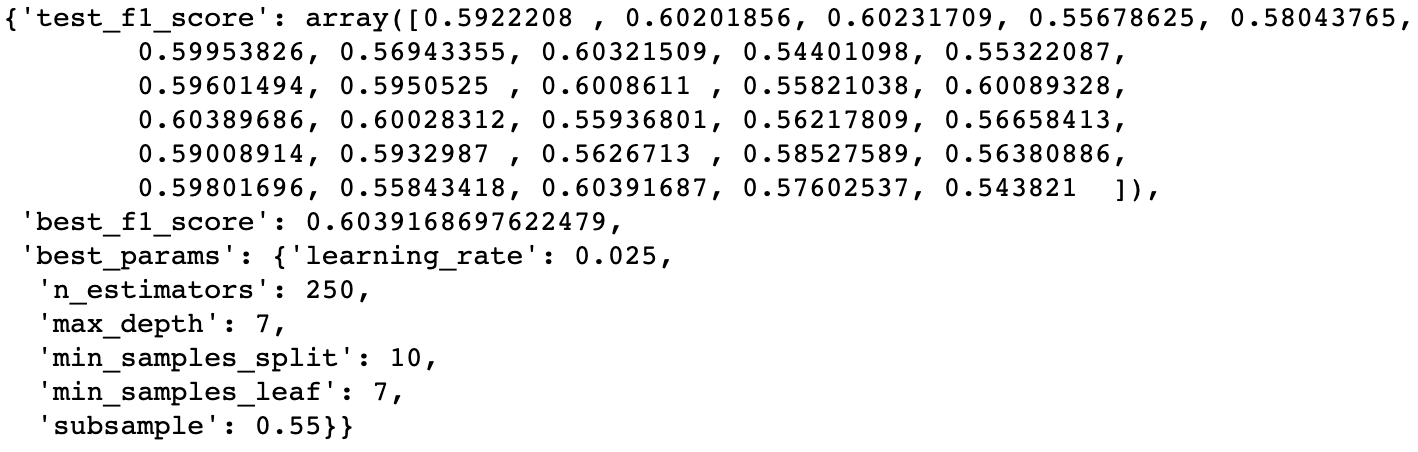

In [6]:
Image(filename='Screen Shot 2021-04-18 at 2.03.21 PM.png')